In [1]:
## This file replicates main results of the paper
## "Man Versus Machine Learning Revisited"
# by Yingguang (Conson) Zhang, Yandi Zhu, and Juhani T. Linnainmaa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from tqdm import tqdm
from functools import reduce
import statsmodels.api as sm
import scipy.stats as stats
from linearmodels import PanelOLS

from functions import utils
from functions import summary2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams.update({'font.size':13})
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '--'
%config InlineBackend.figure_format = 'retina'

# Load Data

In [3]:
df_tmp = pd.read_parquet('../data/Results/df_train_new.parquet')

In [4]:
crsp = pd.read_parquet('../data/WRDS/crsp_m.parquet')
crsp['prc'] = abs(crsp['prc'])
crsp['ME'] = (crsp['prc']) * crsp['shrout']
crsp.sort_values(by=['permno','YearMonth'], inplace=True)
crsp['bh1m'] = crsp.groupby('permno')['retadj'].shift(-1)
crsp['prc_l1'] = crsp.groupby('permno')['prc'].shift(1)
crsp.duplicated(subset=['permno','YearMonth']).sum()
crsp.rename(columns={'permno':'PERMNO'}, inplace=True)

In [5]:
## w/ look-ahead bias ##
forecast_wLAB = pd.read_parquet('../data/Results/RF_with_lookahead_raw_005.parquet')
forecast_wLAB = forecast_wLAB.merge(df_tmp[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_wLAB['BE_Q1'] = (forecast_wLAB['AF_q1'] - forecast_wLAB['RF_q1']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_Q2'] = (forecast_wLAB['AF_q2'] - forecast_wLAB['RF_q2']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_Q3'] = (forecast_wLAB['AF_q3'] - forecast_wLAB['RF_q3']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_A1'] = (forecast_wLAB['AF_y1'] - forecast_wLAB['RF_y1']) / forecast_wLAB['prc_l1']
forecast_wLAB['BE_A2'] = (forecast_wLAB['AF_y2'] - forecast_wLAB['RF_y2']) / forecast_wLAB['prc_l1']

nonNA = (~forecast_wLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].isna()).sum(axis=1)
forecast_wLAB['BE_Avg'] = np.where(nonNA>1,forecast_wLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].mean(axis=1,),np.nan)

In [6]:
## w/o look-ahead bias
forecast_woLAB = pd.read_parquet('../data/Results/RF_wo_lookahead_raw_005.parquet')
forecast_woLAB = forecast_woLAB.merge(df_tmp[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_woLAB['BE_Q1'] = (forecast_woLAB['AF_q1'] - forecast_woLAB['RF_q1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q2'] = (forecast_woLAB['AF_q2'] - forecast_woLAB['RF_q2']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q3'] = (forecast_woLAB['AF_q3'] - forecast_woLAB['RF_q3']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A1'] = (forecast_woLAB['AF_y1'] - forecast_woLAB['RF_y1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A2'] = (forecast_woLAB['AF_y2'] - forecast_woLAB['RF_y2']) / forecast_woLAB['prc_l1']

nonNA = (~forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].isna()).sum(axis=1)
forecast_woLAB['BE_Avg'] = np.where(nonNA>1,forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].mean(axis=1,),np.nan)

# Table 3

In [7]:
## Panel B of Table 3 ##
## w/ look-ahead bias ##
summary_table = []
for i in [1,2,3]:
    forecast_all = forecast_wLAB.dropna(subset=[f'RF_q{i}',f'AE_q{i}',f'AF_q{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}'])**2

    mean_t = forecast_all.groupby('YearMonth')[[f'RF_q{i}',f'AF_q{i}',f'AE_q{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Q{i}'
    summary_table.append(mean)

for i in [1,2]:
    forecast_all = forecast_wLAB.dropna(subset=[f'RF_y{i}',f'AE_y{i}',f'AF_y{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}'])**2

    mean_t = forecast_all.groupby('YearMonth')[[f'RF_y{i}',f'AF_y{i}',f'AE_y{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Y{i}'
    summary_table.append(mean)

rlt = pd.concat(summary_table, axis=1).T[['RF','AF','AE','RF-AE','t(RF-AE)','AF-AE','t(AF-AE)','(RF-AE)2','(AF-AE)2','Obs']]
rlt.to_clipboard()
rlt

,RF,AF,AE,RF-AE,t(RF-AE),AF-AE,t(AF-AE),(RF-AE)2,(AF-AE)2,Obs
Q1,0.288,0.317,0.289,-0.001,-0.373,0.028,6.502,0.071,0.078,1024654.0
Q2,0.319,0.374,0.323,-0.004,-0.831,0.051,10.174,0.087,0.096,1119537.0
Q3,0.338,0.411,0.341,-0.002,-0.402,0.070,11.377,0.111,0.125,1026893.0
Y1,1.184,1.306,1.157,0.027,1.887,0.149,6.136,0.602,0.655,1265472.0
Y2,1.349,1.727,1.359,-0.011,-0.204,0.368,8.261,1.643,1.856,1136233.0


In [8]:
### Panel C of Table 3 ###
## w/o look-ahead bias
summary_table = []
for i in [1,2,3]:
    forecast_all = forecast_woLAB.dropna(subset=[f'RF_q{i}',f'AE_q{i}',f'AF_q{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_q{i}'] - forecast_all[f'AE_q{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_q{i}'] - forecast_all[f'AE_q{i}'])**2

    mean_t = forecast_all.groupby('YearMonth')[[f'RF_q{i}',f'AF_q{i}',f'AE_q{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Q{i}'
    summary_table.append(mean)
    # break

for i in [1,2]:
    forecast_all = forecast_woLAB.dropna(subset=[f'RF_y{i}',f'AE_y{i}',f'AF_y{i}']).copy()
    forecast_all['RF-AE'] = forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['AF-AE'] = forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}']
    forecast_all['(RF-AE)2'] = (forecast_all[f'RF_y{i}'] - forecast_all[f'AE_y{i}'])**2
    forecast_all['(AF-AE)2'] = (forecast_all[f'AF_y{i}'] - forecast_all[f'AE_y{i}'])**2

    mean_t = forecast_all.groupby('YearMonth')[[f'RF_y{i}',f'AF_y{i}',f'AE_y{i}','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']].mean()
    mean = mean_t.mean().round(3)
    mean.index = ['RF','AF','AE','RF-AE','AF-AE','(RF-AE)2','(AF-AE)2']
    mean['t(RF-AE)'] = sm.OLS(mean_t['RF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['t(AF-AE)'] = sm.OLS(mean_t['AF-AE'],exog=[1]*len(mean_t)).fit(cov_type = 'HAC', cov_kwds = {'maxlags':12}).tvalues['const']
    mean['Obs'] = forecast_all.shape[0]
    mean = mean.round(3)
    mean.name = f'Y{i}'
    summary_table.append(mean)

rlt = pd.concat(summary_table, axis=1).T[['RF','AF','AE','RF-AE','t(RF-AE)','AF-AE','t(AF-AE)','(RF-AE)2','(AF-AE)2','Obs']]
rlt.to_clipboard()
rlt

,RF,AF,AE,RF-AE,t(RF-AE),AF-AE,t(AF-AE),(RF-AE)2,(AF-AE)2,Obs
Q1,0.288,0.317,0.289,-0.001,-0.373,0.028,6.502,0.071,0.078,1024654.0
Q2,0.318,0.374,0.323,-0.004,-0.946,0.051,10.174,0.090,0.096,1119537.0
Q3,0.337,0.411,0.341,-0.003,-0.510,0.070,11.377,0.120,0.125,1026893.0
Y1,1.184,1.306,1.157,0.027,1.887,0.149,6.136,0.602,0.655,1265472.0
Y2,1.356,1.727,1.359,-0.004,-0.072,0.368,8.261,1.805,1.856,1136233.0


In [9]:
## Panel C of Table 3: Accuracy Compare
mse = []
for h in ['q1','q2','q3','y1','y2']:
    mse.append(((forecast_wLAB[f'RF_{h}'] - forecast_wLAB[f'AE_{h}'])**2).groupby(forecast_wLAB['YearMonth']).mean())
mse_wLAB = pd.concat(mse, axis=1)

mse = []
for h in ['q1','q2','q3','y1','y2']:
    mse.append(((forecast_woLAB[f'RF_{h}'] - forecast_woLAB[f'AE_{h}'])**2).groupby(forecast_woLAB['YearMonth']).mean())
mse_woLAB = pd.concat(mse, axis=1)

# Hughes et al. (2008)
forecast_Hughes = pd.read_parquet('../data/Results/Hughes_eps.parquet')
mse = []
for h in ['q1','q2','q3','y1','y2']:
    mse.append(((forecast_Hughes[f'LF_{h}'] - forecast_Hughes[f'AE_{h}'])**2).groupby(forecast_Hughes['YearMonth']).mean())
mse_Hughes = pd.concat(mse, axis=1)

In [10]:
## Compare MSE between w/ and w/o look-ahead bias
mdl = []
for i in range(5):
    mdl.append(sm.OLS(endog=mse_wLAB[i]-mse_woLAB[i],
                      exog=[1]*len(mse_woLAB)).fit(cov_type = 'HAC',
                                                 cov_kwds = {'maxlags':12}))
rlts = summary2.summary_col(mdl, float_format='%.3f')
rlts.to_clipboard()
rlts

,y,1,2,3,4
const,0.000,-0.003,-0.009,0.000,-0.161
,(nan),(-6.48),(-6.84),(nan),(-10.50)


In [11]:
## Compare MSE between w/o look-ahead bias and Hughes et al. (2008)
mdl = []
for i in range(5):
    mdl.append(sm.OLS(endog=mse_Hughes[i]-mse_woLAB[i],
                      exog=[1]*len(mse_woLAB)).fit(cov_type = 'HAC',
                                                 cov_kwds = {'maxlags':12}))
rlts = summary2.summary_col(mdl, float_format='%.3f')
rlts.to_clipboard()
rlts

,y,1,2,3,4
const,0.002,0.003,0.004,-0.005,-0.003
,(1.30),(1.10),(0.91),(-0.63),(-0.05)


In [12]:
# Pre 2006 and Post 2006
diff_mse = mse_Hughes - mse_woLAB
mdl = []
for i in range(5):
    ## Hughes et al. (2008) uses actual earnings data ends in 2006 and forecast data ends in 2004
    # we split the data by 2004-12 to be consistent with Hughes et al. (2008)
    pre_2006 = diff_mse[diff_mse.index<'2004-12-31']
    mdl.append(sm.OLS(endog=pre_2006[i],
                      exog=[1]*len(pre_2006)).fit(cov_type = 'HAC',
                                                 cov_kwds = {'maxlags':12}))
rlts = summary2.summary_col(mdl, float_format='%.3f')
rlts.to_clipboard()
rlts

,y,1,2,3,4
const,0.001,-0.000,-0.002,-0.006,-0.003
,(0.81),(-0.07),(-0.82),(-0.71),(-0.10)


In [13]:
mdl = []
for i in range(5):
    post_2006 = diff_mse[diff_mse.index>'2004-12-31']
    mdl.append(sm.OLS(endog=post_2006[i],
                      exog=[1]*len(post_2006)).fit(cov_type = 'HAC',
                                                 cov_kwds = {'maxlags':12}))
rlts = summary2.summary_col(mdl, float_format='%.3f')
rlts.to_clipboard()
rlts

,y,1,2,3,4
const,0.004,0.006,0.011,-0.004,-0.003
,(1.16),(1.16),(1.27),(-0.28),(-0.02)


# Table 4

In [14]:
forecast_wLAB = forecast_wLAB[['permno','YearMonth',
                               'BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2',
                               'RF_q1','RF_q2','RF_q3','RF_y1','RF_y2',
                               'BE_Avg',
                              ]].copy()
forecast_wLAB.set_index(['permno','YearMonth'], inplace=True)
forecast_wLAB.columns = [ f'{c}_wLAB' for c in forecast_wLAB.columns]

In [15]:
forecast_woLAB = forecast_woLAB[['permno','YearMonth',
                               'BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2',
                               'RF_q1','RF_q2','RF_q3','RF_y1','RF_y2',
                               'BE_Avg',
                              ]].copy()
forecast_woLAB.set_index(['permno','YearMonth'], inplace=True)
forecast_woLAB.columns = [ f'{c}_woLAB' for c in forecast_woLAB.columns]

In [16]:
Bias_all = forecast_wLAB.merge(forecast_woLAB, on=['permno','YearMonth'])
# Test df
df = df_tmp.merge(Bias_all, on=['permno','YearMonth'])

In [17]:
all_factor = pd.read_csv('../data/Other/ff5_factors_m.CSV')
all_factor['YearMonth'] = pd.to_datetime(all_factor['yyyymm'], format='%Y%m') + MonthEnd(0)
# We do sort at the end of month t and use the return of month t+1
# So we need to shift the factor return by 1 month
all_factor['YearMonth'] = all_factor['YearMonth'] + MonthEnd(-1)

factor_dict = {'Ret':['ones'],
              }
factor_dict2 = {'CAPM':['ones','Mkt_RF'],
               'FF3':['ones','Mkt_RF','SMB','HML'],
               'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
              }

In [18]:
# Table 4: Replication with look-ahead bias
sort_var = 'BE_Avg_wLAB'
num_level = 5
_,vwret2 = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
result2 = utils.SingleSort_RetAna(_,vwret2,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result2.to_clipboard()
result2

Var:BE_Avg_wLAB, Delete 91707 rows due to missing values, raw data 1370066 rows --> new data 1278359 rows


,1,2,3,4,5,H-L
Ret,1.38,0.92,0.61,0.24,-0.21,-1.59
,(6.74),(4.23),(2.44),(0.78),(-0.51),(-5.08)


In [19]:
# Table 4: Replication without look-ahead bias
sort_var = 'BE_Avg_woLAB'
num_level = 5
_,vwret3 = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
result3 = utils.SingleSort_RetAna(_,vwret3,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result3.to_clipboard()
result3

Var:BE_Avg_woLAB, Delete 91707 rows due to missing values, raw data 1370066 rows --> new data 1278359 rows


,1,2,3,4,5,H-L
Ret,0.99,0.90,0.91,0.85,0.75,-0.25
,(4.83),(4.10),(3.62),(2.78),(1.81),(-0.80)


# Table 1 & 5 & 6

In [20]:
def merge_by_col(df1,df2):
    '''
    Merge two dataframes: (coefs) and (standard-errors) side-by-side
    '''
    new_columns = []

    for col_name in df1.columns:
        new_columns.append(df1[col_name])
        new_columns.append(df2[col_name])

    df_merged = pd.concat(new_columns, axis=1)

    new_col_names = []
    for i, col_name in enumerate(df1.columns):
        new_col_names.append(col_name)
        new_col_names.append('')

    df_merged.columns = new_col_names

    return df_merged

def Factor_Exposure(vwret, num_level, time_id, factor_data, factor_dict, lag, regressor_order=['ones']):
    '''
    This function is used to get common risk factor exposure
    vwret is output from SingleSort
    e.g.:
        Factor_Exposure(vwret1, num_level, 'YearMonth',
                        all_factor, factor_dict2, 12,
                        regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    '''
    vwret = vwret.merge(factor_data, left_index=True, right_on=time_id)
    vwret['ones'] = 1
    coefs = []
    coefs_t = []

    # For each test factor model
    for name, factor_list in factor_dict.items():

        model_i = sm.OLS(endog=vwret['H-L'],
                         exog=vwret[factor_list],
                         missing='drop')
        if lag:
            model_i = model_i.fit(cov_type = 'HAC', cov_kwds = {'maxlags':lag})
        else:
            model_i = model_i.fit(cov_type = 'HC0')

        coefs.append(summary2.summary_params(model_i)['Coef.'].rename(name))
        coefs_t.append(summary2.summary_params(model_i)['t'].rename(name))
        # model.append(model_i)

    coefs = pd.concat(coefs,axis=1)
    coefs_t = pd.concat(coefs_t,axis=1)
    result = merge_by_col(coefs, coefs_t)
    return result

In [21]:
# Table 1 With Look-ahead Bias & Panel B of Table 5
exposure2 = Factor_Exposure(vwret2, num_level, 'YearMonth',
                all_factor, factor_dict2, None, regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
exposure2.to_clipboard()
exposure2.round(2)

,CAPM,,FF3,,FF5,
ones,-2.00,-7.25,-2.10,-8.63,-1.71,-6.07
Mkt_RF,0.61,7.49,0.56,7.56,0.43,5.71
SMB,NaN,NaN,0.88,7.22,0.66,5.14
HML,NaN,NaN,0.62,5.35,0.90,6.27
RMW,NaN,NaN,NaN,NaN,-0.75,-4.01
CMA,NaN,NaN,NaN,NaN,-0.30,-1.09


In [22]:
# Table 1 Without Look-ahead Bias & Panel C of Table 5
exposure3 = Factor_Exposure(vwret3, num_level, 'YearMonth',
                all_factor, factor_dict2, None, regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
exposure3.to_clipboard()
exposure3.round(2)

,CAPM,,FF3,,FF5,
ones,-0.67,-2.45,-0.76,-3.26,-0.41,-1.54
Mkt_RF,0.61,7.75,0.55,7.83,0.44,5.94
SMB,NaN,NaN,0.96,7.82,0.75,5.69
HML,NaN,NaN,0.61,5.48,0.84,5.90
RMW,NaN,NaN,NaN,NaN,-0.72,-3.83
CMA,NaN,NaN,NaN,NaN,-0.18,-0.67


In [23]:
# Alternative factor model: Table 6
sort_var = 'BE_Avg_woLAB'
num_level = 5
factor_dict = {'FFC6':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA','MOM'],
               'q4':['ones','R_MKT','R_ME','R_IA','R_ROE'],
               'q-factor':['ones','R_MKT','R_ME','R_IA','R_ROE','R_EG'],
               'SY':['ones','Mkt_RF','SMB_SY','MGMT', 'PERF'],
               'DHS':['ones','Mkt_RF','PEAD', 'FIN'],
              }
_,vwret3 = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
result3 = utils.SingleSort_RetAna(_,vwret3,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result3.to_clipboard()
result3

Var:BE_Avg_woLAB, Delete 91707 rows due to missing values, raw data 1370066 rows --> new data 1278359 rows


,1,2,3,4,5,H-L
FFC6,0.29,0.18,0.26,0.31,0.27,-0.02
,(6.81),(3.62),(3.33),(2.70),(1.54),(-0.11)
q4,0.29,0.18,0.22,0.25,0.21,-0.08
,(5.69),(3.31),(2.02),(1.53),(0.84),(-0.27)
q-factor,0.27,0.16,0.24,0.32,0.26,-0.01
,(5.44),(2.82),(2.16),(1.93),(0.97),(-0.02)
SY,0.28,0.21,0.33,0.42,0.35,0.07
,(5.79),(3.60),(3.20),(2.77),(1.37),(0.25)
DHS,0.25,0.17,0.28,0.38,0.56,0.31
,(4.47),(3.02),(2.49),(2.01),(1.76),(0.87)


# Table 7

In [24]:
## With look-ahead bias
vwret = vwret2
pre_2000 = vwret[vwret.index<='1999-12-31']
post_2000 = vwret[vwret.index>'1999-12-31']

mdl1 = sm.OLS(endog=vwret['H-L'], exog=[1]*len(vwret)).fit(cov_type = 'HC0')
mdl2 = sm.OLS(endog=pre_2000['H-L'], exog=[1]*len(pre_2000)).fit(cov_type = 'HC0')
mdl3 = sm.OLS(endog=post_2000['H-L'], exog=[1]*len(post_2000)).fit(cov_type = 'HC0')
rlt = summary2.summary_col([mdl1, mdl2, mdl3], float_format='%.2f')
rlt['Pre-Post'] = [np.round(pre_2000['H-L'].mean() - post_2000['H-L'].mean(),2),
                   np.round(stats.ttest_ind(pre_2000['H-L'], post_2000['H-L']).pvalue,2)
                  ]
rlt.to_clipboard()
rlt

,H-L I,H-L II,H-L III,Pre-Post
const,-1.59,-1.82,-1.42,-0.40
,(-5.08),(-4.63),(-3.14),0.53


In [25]:
## Without look-ahead bias
vwret = vwret3
pre_2000 = vwret[vwret.index<='1999-12-31']
post_2000 = vwret[vwret.index>'1999-12-31']

mdl1 = sm.OLS(endog=vwret['H-L'], exog=[1]*len(vwret)).fit(cov_type = 'HC0')
mdl2 = sm.OLS(endog=pre_2000['H-L'], exog=[1]*len(pre_2000)).fit(cov_type = 'HC0')
mdl3 = sm.OLS(endog=post_2000['H-L'], exog=[1]*len(post_2000)).fit(cov_type = 'HC0')
rlt = summary2.summary_col([mdl1, mdl2, mdl3], float_format='%.2f')
rlt['Pre-Post'] = [np.round(pre_2000['H-L'].mean() - post_2000['H-L'].mean(),2),
                   np.round(stats.ttest_ind(pre_2000['H-L'], post_2000['H-L']).pvalue,2)
                  ]
rlt.to_clipboard()
rlt

,H-L I,H-L II,H-L III,Pre-Post
const,-0.25,-0.52,-0.06,-0.46
,(-0.80),(-1.35),(-0.13),0.47


# Figure 2

In [26]:
#######################################################################
## To replicate this figure, we need earnings forecast data from BHL ##
#######################################################################
## BHL
forecast_ORIG = pd.read_csv('../data/BHL/Conditional_Bias.csv')
forecast_ORIG['DATE'] = pd.to_datetime(forecast_ORIG['DATE'],format='%Y-%m') + MonthEnd(0)
forecast_ORIG.rename(columns={'PERMNO':'permno','DATE':'YearMonth'}, inplace=True)
df = df.merge(forecast_ORIG, on=['permno','YearMonth'], how='left')

In [27]:
num_level = 5
_,vwret1 = utils.SingleSort(df.dropna(subset=['Avg_bias','BE_Avg_wLAB','BE_Avg_woLAB']),
                             'PERMNO', 'YearMonth', 'Avg_bias', 'bh1m', num_level, 'ME', quantile_filter=None)
_,vwret2 = utils.SingleSort(df.dropna(subset=['Avg_bias','BE_Avg_wLAB','BE_Avg_woLAB']),
                             'PERMNO', 'YearMonth', 'BE_Avg_wLAB', 'bh1m', num_level, 'ME', quantile_filter=None)
_,vwret3 = utils.SingleSort(df.dropna(subset=['Avg_bias','BE_Avg_wLAB','BE_Avg_woLAB']),
                             'PERMNO', 'YearMonth', 'BE_Avg_woLAB', 'bh1m', num_level, 'ME', quantile_filter=None)

Var:Avg_bias, Delete 24 rows due to missing values, raw data 1231112 rows --> new data 1231088 rows
Var:BE_Avg_wLAB, Delete 24 rows due to missing values, raw data 1231112 rows --> new data 1231088 rows
Var:BE_Avg_woLAB, Delete 24 rows due to missing values, raw data 1231112 rows --> new data 1231088 rows


In [28]:
vwret1['H-L'].corr(vwret2['H-L'])

0.9484238359248416

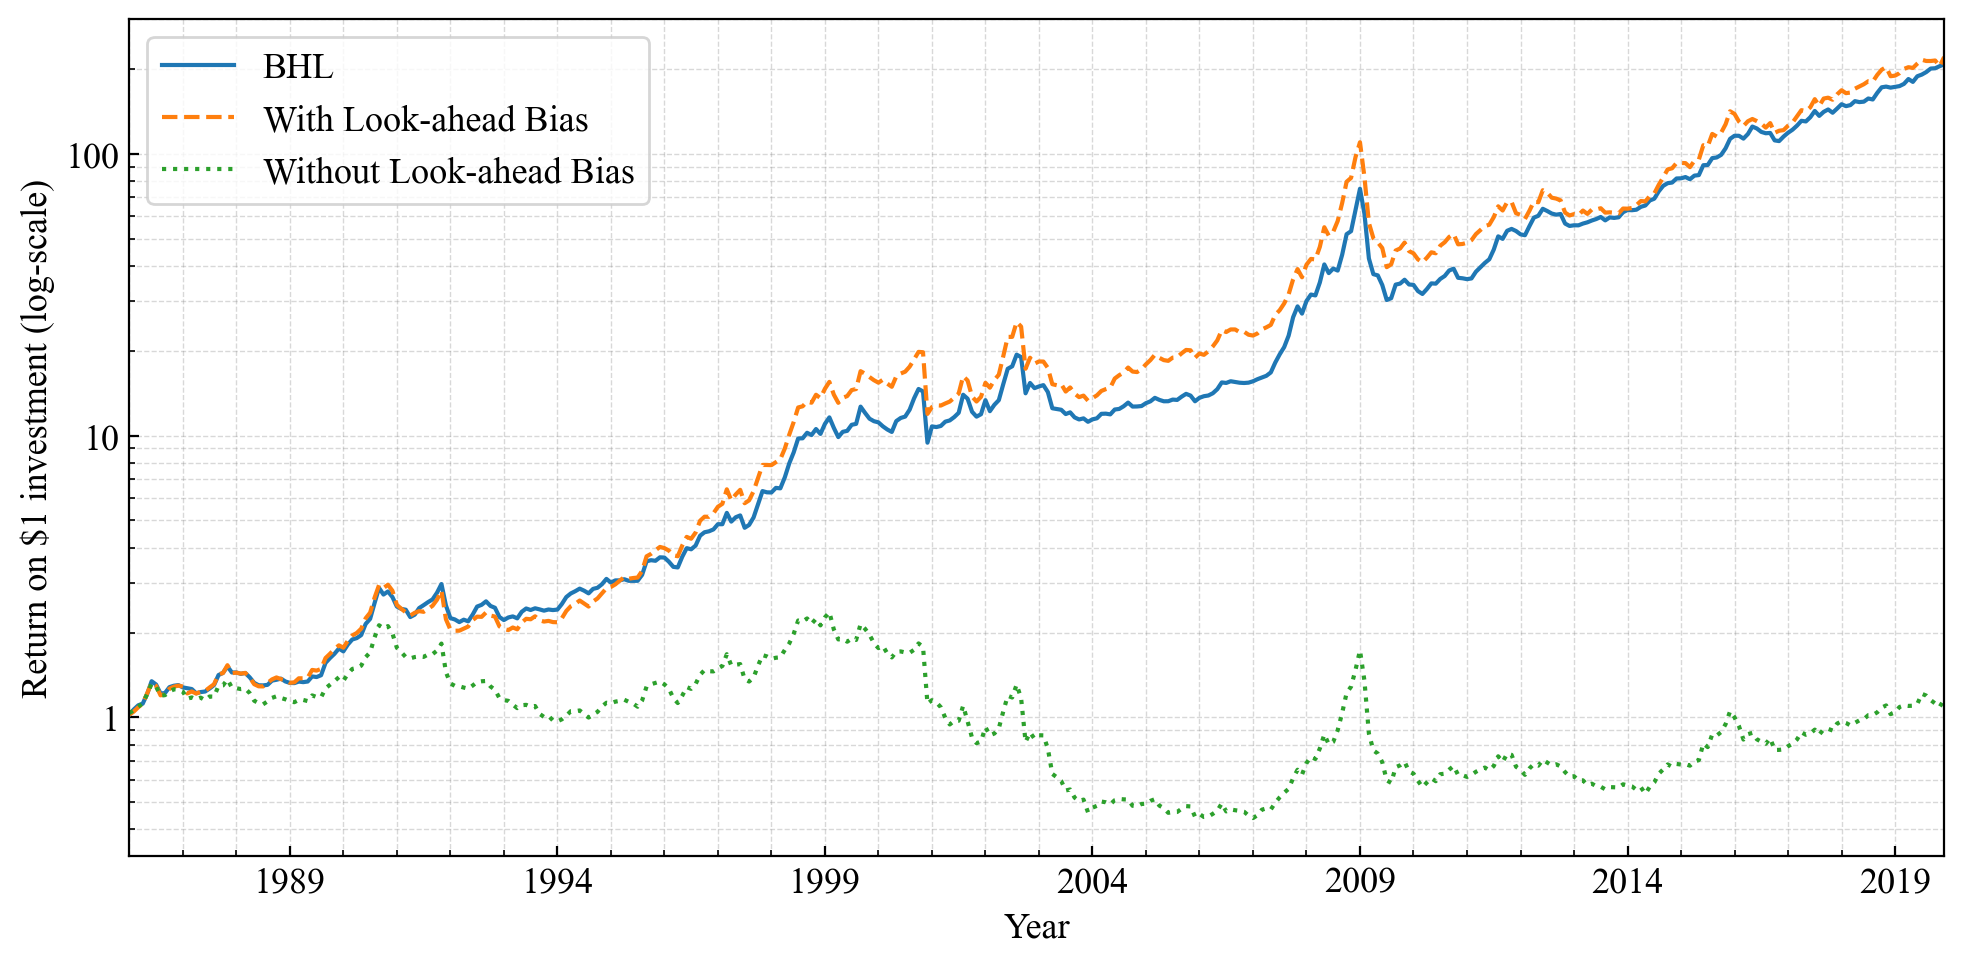

In [29]:
## Figure 2
(1-vwret1['H-L']/100).cumprod().plot(figsize=(10,5), label='BHL')
(1-vwret2['H-L']/100).cumprod().plot(figsize=(10,5), label='With Look-ahead Bias', linestyle='--')
(1-vwret3['H-L']/100).cumprod().plot(figsize=(10,5), label='Without Look-ahead Bias', linestyle=':',)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)
plt.legend()
plt.yticks([1,10,100],[1,10,100])
plt.xlabel('Year')
plt.ylabel('Return on $1 investment (log-scale)')
plt.tight_layout()
plt.savefig('../data/Results/cumret.png',dpi=500)

# Table C.1

In [30]:
## Equal-weighted Portfolios ##
df['ones'] = 1
## With look-ahead bias
sort_var = 'BE_Avg_wLAB'
num_level = 5
factor_dict = {'Ret':['ones'],
               'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
              }

_,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ones', quantile_filter=None)
result = utils.SingleSort_RetAna(_,vwret,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result.to_clipboard()
result

Var:BE_Avg_wLAB, Delete 91707 rows due to missing values, raw data 1370066 rows --> new data 1278359 rows


,1,2,3,4,5,H-L
Ret,1.82,1.30,0.94,0.57,0.41,-1.41
,(7.31),(5.38),(3.42),(1.79),(0.99),(-5.21)
FF5,1.14,0.56,0.18,-0.19,-0.29,-1.43
,(17.28),(12.03),(2.88),(-1.74),(-1.06),(-4.87)


In [31]:
## Without look-ahead bias
sort_var = 'BE_Avg_woLAB'
num_level = 5
_,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ones', quantile_filter=None)
result = utils.SingleSort_RetAna(_,vwret,'YearMonth',factor_data=all_factor,factor_dict=factor_dict,lag=None)
result.to_clipboard()
result

Var:BE_Avg_woLAB, Delete 91707 rows due to missing values, raw data 1370066 rows --> new data 1278359 rows


,1,2,3,4,5,H-L
Ret,1.14,1.01,0.96,0.86,1.08,-0.07
,(4.59),(4.11),(3.47),(2.70),(2.59),(-0.24)
FF5,0.49,0.26,0.18,0.09,0.38,-0.11
,(7.38),(5.89),(2.83),(0.79),(1.36),(-0.37)


# Table C.2

In [32]:
## Fama-macbeth Regression
# Panel A of Table C.3: Replication with look-ahead bias
results = []
for idx in ['Q1','Q2','Q3','A1','A2','Avg']:
    df_tmp = df[['YearMonth','bh1m',f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']].dropna().copy()
    df_tmp[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']] = df_tmp.groupby('YearMonth',group_keys=False)[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']]\
                         .transform(lambda x: x.clip(x.quantile(0.01),x.quantile(0.99)))
    rlt = utils.fama_macbeth(df_tmp,
                   formula_list = [f'bh1m~BE_{idx}_wLAB'],
                   time_id='YearMonth', lags=12, stars=False)
    rlt = rlt.rename(index={f'BE_{idx}_wLAB':'Bias'})
    results.append(rlt)

results = pd.concat(results,axis=1)
results.to_clipboard()
results

,1,1,1,1,1,1
Intercept,0.0101,0.0116,0.0128,0.0095,0.0123,0.0109
,(4.01),(4.78),(5.28),(3.99),(5.30),(4.56)
Bias,-0.2142,-0.5143,-0.6188,0.0038,-0.0890,-0.1758
,(-1.78),(-5.17),(-6.81),(0.10),(-4.60),(-3.35)
N,1024253,1119064,1026432,1264906,1135687,1278359
R2,1.1319,1.0866,1.1637,1.2003,1.1966,1.1983


In [33]:
# Panel B of Table C.3: Replication without look-ahead bias
results = []
for idx in ['Q1','Q2','Q3','A1','A2','Avg']:
    df_tmp = df[['YearMonth','bh1m',f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']].dropna().copy()
    df_tmp[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']] = df_tmp.groupby('YearMonth',group_keys=False)[[f'BE_{idx}_wLAB',f'BE_{idx}_woLAB']]\
                         .transform(lambda x: x.clip(x.quantile(0.01),x.quantile(0.99)))
    rlt = utils.fama_macbeth(df_tmp,
                   formula_list = [f'bh1m~BE_{idx}_woLAB'],
                   time_id='YearMonth', lags=12, stars=False)
    rlt = rlt.rename(index={f'BE_{idx}_woLAB':'Bias'})
    results.append(rlt)
results = pd.concat(results,axis=1)
results.to_clipboard()
results

,1,1,1,1,1,1
Intercept,0.0101,0.0100,0.0099,0.0095,0.0095,0.0093
,(4.01),(4.15),(4.20),(3.99),(4.17),(3.91)
Bias,-0.2142,-0.0859,-0.0574,0.0038,0.0135,-0.0075
,(-1.78),(-0.78),(-0.56),(0.10),(0.68),(-0.15)
N,1024253,1119064,1026432,1264906,1135687,1278359
R2,1.1319,1.0569,1.0787,1.2003,1.1296,1.1443


# Table C.3

In [34]:
# By Horizon without look-ahead bias: raw return (Panel A)
rlts = []
for sort_var in ['BE_Q1_woLAB','BE_Q2_woLAB','BE_Q3_woLAB','BE_A1_woLAB','BE_A2_woLAB']:
    _,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
    exposure = Factor_Exposure(vwret, num_level, 'YearMonth',
                all_factor, {'Return':['ones'],
              }, None,
                regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    rlts.append(exposure)
    # break
rlts = pd.concat(rlts, axis=1)
rlts.columns = ['Q1','','Q2','','Q3','','A1','','A2','']
rlts.to_clipboard()
rlts

Var:BE_Q1_woLAB, Delete 345813 rows due to missing values, raw data 1370066 rows --> new data 1024253 rows
Var:BE_Q2_woLAB, Delete 251002 rows due to missing values, raw data 1370066 rows --> new data 1119064 rows
Var:BE_Q3_woLAB, Delete 343634 rows due to missing values, raw data 1370066 rows --> new data 1026432 rows
Var:BE_A1_woLAB, Delete 105160 rows due to missing values, raw data 1370066 rows --> new data 1264906 rows
Var:BE_A2_woLAB, Delete 234379 rows due to missing values, raw data 1370066 rows --> new data 1135687 rows


,Q1,,Q2,,Q3,,A1,,A2,
ones,-0.39359,-1.375036,-0.373432,-1.231261,-0.211208,-0.707617,-0.206421,-0.704115,0.076461,0.261529


In [35]:
# By Horizon without look-ahead bias: CAPM (Panel B)
rlts = []
for sort_var in ['BE_Q1_woLAB','BE_Q2_woLAB','BE_Q3_woLAB','BE_A1_woLAB','BE_A2_woLAB']:
    _,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
    exposure = Factor_Exposure(vwret, num_level, 'YearMonth',
                all_factor, {'CAPM':['ones','Mkt_RF'],
              }, None,
                regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    rlts.append(exposure)
    # break
rlts = pd.concat(rlts, axis=1)
rlts.columns = ['Q1','','Q2','','Q3','','A1','','A2','']
rlts.to_clipboard()
rlts

Var:BE_Q1_woLAB, Delete 345813 rows due to missing values, raw data 1370066 rows --> new data 1024253 rows
Var:BE_Q2_woLAB, Delete 251002 rows due to missing values, raw data 1370066 rows --> new data 1119064 rows
Var:BE_Q3_woLAB, Delete 343634 rows due to missing values, raw data 1370066 rows --> new data 1026432 rows
Var:BE_A1_woLAB, Delete 105160 rows due to missing values, raw data 1370066 rows --> new data 1264906 rows
Var:BE_A2_woLAB, Delete 234379 rows due to missing values, raw data 1370066 rows --> new data 1135687 rows


,Q1,,Q2,,Q3,,A1,,A2,
ones,-0.753351,-2.940689,-0.762855,-2.811598,-0.596096,-2.221598,-0.573444,-2.208524,-0.291606,-1.139636
Mkt_RF,0.522915,6.884365,0.566031,7.069131,0.559438,6.760112,0.533472,6.657156,0.534989,7.102960


In [36]:
# By Horizon without look-ahead bias: FF3 (Panel C)
rlts = []
for sort_var in ['BE_Q1_woLAB','BE_Q2_woLAB','BE_Q3_woLAB','BE_A1_woLAB','BE_A2_woLAB']:
    _,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
    exposure = Factor_Exposure(vwret, num_level, 'YearMonth',
                all_factor, {
                    # 'CAPM':['ones','Mkt_RF'],
               'FF3':['ones','Mkt_RF','SMB','HML'],
            #    'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
              }, None,
                regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    rlts.append(exposure)
    # break
rlts = pd.concat(rlts, axis=1)
rlts.columns = ['Q1','','Q2','','Q3','','A1','','A2','']
rlts.to_clipboard()
rlts

Var:BE_Q1_woLAB, Delete 345813 rows due to missing values, raw data 1370066 rows --> new data 1024253 rows
Var:BE_Q2_woLAB, Delete 251002 rows due to missing values, raw data 1370066 rows --> new data 1119064 rows
Var:BE_Q3_woLAB, Delete 343634 rows due to missing values, raw data 1370066 rows --> new data 1026432 rows
Var:BE_A1_woLAB, Delete 105160 rows due to missing values, raw data 1370066 rows --> new data 1264906 rows
Var:BE_A2_woLAB, Delete 234379 rows due to missing values, raw data 1370066 rows --> new data 1135687 rows


,Q1,,Q2,,Q3,,A1,,A2,
ones,-0.799405,-3.511633,-0.873279,-3.655010,-0.695454,-2.922000,-0.633699,-2.743120,-0.366945,-1.632272
Mkt_RF,0.453586,6.135621,0.532813,7.249786,0.521859,6.807603,0.469598,6.003183,0.475911,6.802615
SMB,0.842193,9.014884,0.839519,7.619949,0.823600,7.149205,0.863882,7.963840,0.895775,7.280442
HML,0.374807,3.055212,0.651214,5.890111,0.600262,5.369495,0.440459,3.760076,0.512052,4.267743


In [37]:
# By Horizon without look-ahead bias: FF5 (Panel D)
rlts = []
for sort_var in ['BE_Q1_woLAB','BE_Q2_woLAB','BE_Q3_woLAB','BE_A1_woLAB','BE_A2_woLAB']:
    _,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
    exposure = Factor_Exposure(vwret, num_level, 'YearMonth',
                all_factor, {
                    # 'CAPM':['ones','Mkt_RF'],
            #    'FF3':['ones','Mkt_RF','SMB','HML'],
               'FF5':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA'],
              }, None,
                regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    rlts.append(exposure)
    # break
rlts = pd.concat(rlts, axis=1)
rlts.columns = ['Q1','','Q2','','Q3','','A1','','A2','']
rlts.to_clipboard()
rlts

Var:BE_Q1_woLAB, Delete 345813 rows due to missing values, raw data 1370066 rows --> new data 1024253 rows
Var:BE_Q2_woLAB, Delete 251002 rows due to missing values, raw data 1370066 rows --> new data 1119064 rows
Var:BE_Q3_woLAB, Delete 343634 rows due to missing values, raw data 1370066 rows --> new data 1026432 rows
Var:BE_A1_woLAB, Delete 105160 rows due to missing values, raw data 1370066 rows --> new data 1264906 rows
Var:BE_A2_woLAB, Delete 234379 rows due to missing values, raw data 1370066 rows --> new data 1135687 rows


,Q1,,Q2,,Q3,,A1,,A2,
ones,-0.324637,-1.340735,-0.489497,-1.813603,-0.289217,-1.095059,-0.186789,-0.721783,-0.062197,-0.247885
Mkt_RF,0.294791,4.548778,0.404366,5.357903,0.382339,5.000063,0.319362,4.248418,0.372559,4.960869
SMB,0.570303,5.435434,0.620231,5.190865,0.612485,4.929681,0.612421,5.071398,0.729656,5.471903
HML,0.712360,4.923879,0.924650,6.832774,0.913938,6.639143,0.763372,5.091116,0.738422,4.726030
RMW,-0.922994,-5.865790,-0.744778,-4.264139,-0.732050,-3.954745,-0.856835,-5.047145,-0.569930,-3.025561
CMA,-0.341515,-1.465084,-0.278139,-1.040012,-0.382185,-1.427190,-0.340183,-1.298105,-0.254332,-0.954854


In [38]:
# Alphas under alternative factor models (Panel E)
rlts = []

for sort_var in ['BE_Q1_woLAB','BE_Q2_woLAB','BE_Q3_woLAB','BE_A1_woLAB','BE_A2_woLAB']:
    _,vwret = utils.SingleSort(df,
                             'PERMNO', 'YearMonth', sort_var, 'bh1m', num_level, 'ME', quantile_filter=None)
    exposure = Factor_Exposure(vwret, num_level, 'YearMonth',
                all_factor, {
               'FFC6':['ones','Mkt_RF','SMB', 'HML', 'RMW', 'CMA','MOM'],
               'HXZ':['ones','R_MKT','R_ME','R_IA','R_ROE'],
               'HMXZ':['ones','R_MKT','R_ME','R_IA','R_ROE','R_EG'],
               'SY':['ones','Mkt_RF','SMB_SY','MGMT', 'PERF'],
               'DHS':['ones','Mkt_RF','PEAD', 'FIN'],
              }, None,
                regressor_order = ['ones','Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'])
    rlt = exposure.loc['ones',:]
    rlt = pd.DataFrame(rlt.values.reshape(-1,2))
    rlt.index = ['FFC6','HXZ-q4','HMXZ-q5','SY','DHS']
    rlts.append(rlt)
    # break
rlts = pd.concat(rlts, axis=1)
rlts.columns = ['Q1','','Q2','','Q3','','A1','','A2','']
rlts.to_clipboard()
rlts

Var:BE_Q1_woLAB, Delete 345813 rows due to missing values, raw data 1370066 rows --> new data 1024253 rows
Var:BE_Q2_woLAB, Delete 251002 rows due to missing values, raw data 1370066 rows --> new data 1119064 rows
Var:BE_Q3_woLAB, Delete 343634 rows due to missing values, raw data 1370066 rows --> new data 1026432 rows
Var:BE_A1_woLAB, Delete 105160 rows due to missing values, raw data 1370066 rows --> new data 1264906 rows
Var:BE_A2_woLAB, Delete 234379 rows due to missing values, raw data 1370066 rows --> new data 1135687 rows


,Q1,,Q2,,Q3,,A1,,A2,
FFC6,-0.024919,-0.120396,-0.088486,-0.465680,0.118435,0.661571,0.186389,0.917355,0.319211,1.746313
HXZ-q4,-0.035521,-0.147432,-0.199583,-0.703866,0.003803,0.013784,0.145007,0.556162,0.276219,1.057817
HMXZ-q5,0.035565,0.140271,-0.050602,-0.168914,-0.009534,-0.032870,0.195037,0.716725,0.259274,0.966348
SY,-0.050644,-0.207046,0.035831,0.133758,0.114113,0.436086,0.234130,0.854248,0.408804,1.500669
DHS,0.097708,0.300879,0.108753,0.306621,0.303931,0.877188,0.350925,1.024387,0.581792,1.688658


# Table D.1

In [39]:
def _col_params(model):
    res = pd.DataFrame()
    res_se = pd.DataFrame()
    other_info = {}
    def find_stars(p):
        if p <= 0.01:
            return '***'
        elif (p > 0.01) & (p <= 0.05):
            return '**'
        elif (p > 0.05) & (p <= 0.10):
            return '*'
        elif p > 0.1:
            return ''

    res['coef.'] = model.params.round(3) # + model.pvalues.map(find_stars) #+ find_stars(model.pvalues)
    res_se['t-stats'] = model.tstats.round(2)

    other_info['N'] = model.nobs
    other_info['R2'] = model.rsquared
    return res,res_se,other_info

In [40]:
def summary_col(results, regressor_order = None):
    res_all, res_se_all, other_info_all = [], [], []

    for x in results:
        res,res_se,other_info = _col_params(x)
        res_all.append(res)
        res_se_all.append(res_se)
        other_info_all.append(other_info)

    # cols = [_col_params(x) for x in results]
    col_names = [str(i) for i in range(1,len(res_all)+1)]

    res_all = pd.concat(res_all, axis=1)
    res_se_all = pd.concat(res_se_all, axis=1)
    other_info_all = pd.DataFrame(other_info_all).T

    res_all.columns = col_names
    res_se_all.columns = col_names
    other_info_all.columns = col_names

    if regressor_order:
        res_all = res_all.loc[regressor_order,:]
        res_se_all = res_se_all.loc[regressor_order,:]
    else:
        regressor_order = res_all.index

    result = pd.concat([res_all.reset_index(drop=True),
                        res_se_all.reset_index(drop=True)]).sort_index(kind='merge')

    result.index = [item for elem in regressor_order for item in (elem, "")]

    result = pd.concat([result, other_info_all])
    return result

In [41]:
######################################################################
## To replicate this Table, we need earnings forecast data from BHL ##
######################################################################
## Reciver BHL's earnings forecast from bias
df['Forecast_q1'] = df['EPS_ana_q1'] - df['Q1_bias']*df['prc_l1']
df['Forecast_q2'] = df['EPS_ana_q2'] - df['Q2_bias']*df['prc_l1']
df['Forecast_q3'] = df['EPS_ana_q3'] - df['Q3_bias']*df['prc_l1']

df['Forecast_y1'] = df['EPS_ana_y1'] - df['A1_bias']*df['prc_l1']
df['Forecast_y2'] = df['EPS_ana_y2'] - df['A2_bias']*df['prc_l1']

## Q1
df_ = df.dropna(subset = ['EPS_true_q1','Forecast_q1','Forecast_q2',
                          'EPS_true_l1_q1','EPS_ana_q1','EPS_ana_q2',
                          'RF_q1_woLAB','RF_q2_woLAB',
                          'RF_q1_wLAB','RF_q2_wLAB',

                        ])
mdl1 = PanelOLS.from_formula('EPS_true_q1~1 + EPS_ana_q1+EPS_ana_q2+Forecast_q1+Forecast_q2',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl2 = PanelOLS.from_formula('EPS_true_q1~1 + EPS_ana_q1+EPS_ana_q2+RF_q1_wLAB+RF_q2_wLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl3 = PanelOLS.from_formula('EPS_true_q1~1 + EPS_ana_q1+EPS_ana_q2+RF_q1_woLAB+RF_q2_woLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
rlt = summary_col([mdl1, mdl2, mdl3]).round(2)
rlt.to_clipboard()
rlt

,1,2,3
Intercept,0.00,0.01,-0.00
,0.91,5.63,-3.80
EPS_ana_q1,1.03,1.15,0.28
,25.55,22.77,4.93
EPS_ana_q2,-0.68,-0.90,-0.06
,-13.09,-14.47,-1.44
Forecast_q1,-0.05,NaN,NaN
,-1.23,NaN,NaN
Forecast_q2,0.73,NaN,NaN
,13.30,NaN,NaN


In [42]:
## Q2
df_ = df.dropna(subset = ['EPS_true_q2','Forecast_q2','Forecast_q3',
                          'EPS_true_l1_q1','EPS_ana_q2','EPS_ana_q3',
                          'RF_q2_woLAB','RF_q3_woLAB',
                          'RF_q2_wLAB','RF_q3_wLAB',

                        ])

mdl1 = PanelOLS.from_formula('EPS_true_q2~1 + EPS_ana_q2 + EPS_ana_q3 + Forecast_q2+Forecast_q3',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl2 = PanelOLS.from_formula('EPS_true_q2~1 + EPS_ana_q2 + EPS_ana_q3 + RF_q2_wLAB + RF_q3_wLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl3 = PanelOLS.from_formula('EPS_true_q2~1 + EPS_ana_q2 + EPS_ana_q3 + RF_q2_woLAB+RF_q3_woLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
rlt = summary_col([mdl1, mdl2, mdl3]).round(2)
rlt.to_clipboard()
rlt

,1,2,3
Intercept,-0.01,0.00,-0.01
,-3.70,2.13,-7.21
EPS_ana_q2,1.09,1.16,0.46
,26.97,28.94,7.32
EPS_ana_q3,-0.75,-0.93,-0.03
,-20.28,-21.96,-0.94
Forecast_q2,-0.24,NaN,NaN
,-5.32,NaN,NaN
Forecast_q3,0.92,NaN,NaN
,20.17,NaN,NaN


In [43]:
## Y1
df_ = df.dropna(subset = ['EPS_true_y1','Forecast_y1','Forecast_y2',
                          'EPS_true_l1_y1','EPS_ana_y1','EPS_ana_y2',
                          'RF_y1_woLAB','RF_y2_woLAB',
                          'RF_y1_wLAB','RF_y2_wLAB',

                        ])
mdl1 = PanelOLS.from_formula('EPS_true_y1~1 + EPS_ana_y1  + EPS_ana_y2 + Forecast_y1+Forecast_y2',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl2 = PanelOLS.from_formula('EPS_true_y1~1 + EPS_ana_y1 + EPS_ana_y2+ RF_y1_wLAB+RF_y2_wLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
mdl3 = PanelOLS.from_formula('EPS_true_y1~1 + EPS_ana_y1 + EPS_ana_y2+RF_y1_woLAB+RF_y2_woLAB',
                             data=df_.set_index(['permno','YearMonth'])).fit(cov_type='clustered', cluster_time=True, cluster_entity=True, low_memory=True)
rlt = summary_col([mdl1, mdl2, mdl3]).round(2)
rlt.to_clipboard()
rlt

,1,2,3
Intercept,-0.08,-0.02,-0.04
,-11.52,-2.63,-5.34
EPS_ana_y1,1.04,1.22,0.61
,28.93,26.80,13.53
EPS_ana_y2,-0.28,-0.46,-0.12
,-18.51,-22.52,-6.58
Forecast_y1,-0.30,NaN,NaN
,-9.28,NaN,NaN
Forecast_y2,0.58,NaN,NaN
,30.19,NaN,NaN


# Table E.1

In [44]:
# df = pd.read_parquet('./results/df_test.parquet')
# Rational Benchmark w/ LAB
df['RF_q1_wLAB_prc'] = df['RF_q1_wLAB']/df['prc_l1']
df['RF_q2_wLAB_prc'] = df['RF_q2_wLAB']/df['prc_l1']
df['RF_q3_wLAB_prc'] = df['RF_q3_wLAB']/df['prc_l1']
df['RF_y1_wLAB_prc'] = df['RF_y1_wLAB']/df['prc_l1']
df['RF_y2_wLAB_prc'] = df['RF_y2_wLAB']/df['prc_l1']
nonNA = (~df[['RF_q1_wLAB_prc','RF_q2_wLAB_prc','RF_q3_wLAB_prc',
                   'RF_y1_wLAB_prc','RF_y2_wLAB_prc']].isna()).sum(axis=1)
df['RF_wLAB_Avg_prc'] = np.where(nonNA>1,
                             df[['RF_q1_wLAB_prc','RF_q2_wLAB_prc','RF_q3_wLAB_prc',
                                       'RF_y1_wLAB_prc','RF_y2_wLAB_prc']].mean(axis=1,),np.nan)

# Rational Benchmark w/o LAB
df['RF_q1_woLAB_prc'] = df['RF_q1_woLAB']/df['prc_l1']
df['RF_q2_woLAB_prc'] = df['RF_q2_woLAB']/df['prc_l1']
df['RF_q3_woLAB_prc'] = df['RF_q3_woLAB']/df['prc_l1']
df['RF_y1_woLAB_prc'] = df['RF_y1_woLAB']/df['prc_l1']
df['RF_y2_woLAB_prc'] = df['RF_y2_woLAB']/df['prc_l1']
nonNA = (~df[['RF_q1_woLAB_prc','RF_q2_woLAB_prc','RF_q3_woLAB_prc',
                   'RF_y1_woLAB_prc','RF_y2_woLAB_prc']].isna()).sum(axis=1)
df['RF_woLAB_Avg_prc'] = np.where(nonNA>1,
                             df[['RF_q1_woLAB_prc','RF_q2_woLAB_prc','RF_q3_woLAB_prc',
                                       'RF_y1_woLAB_prc','RF_y2_woLAB_prc']].mean(axis=1,),np.nan)

# Analyst Forecast
df['EPS_ana_q1_prc'] = df['EPS_ana_q1']/df['prc_l1']
df['EPS_ana_q2_prc'] = df['EPS_ana_q2']/df['prc_l1']
df['EPS_ana_q3_prc'] = df['EPS_ana_q3']/df['prc_l1']
df['EPS_ana_y1_prc'] = df['EPS_ana_y1']/df['prc_l1']
df['EPS_ana_y2_prc'] = df['EPS_ana_y2']/df['prc_l1']

nonNA = (~df[['EPS_ana_q1_prc','EPS_ana_q2_prc','EPS_ana_q3_prc',
                   'EPS_ana_y1_prc','EPS_ana_y2_prc']].isna()).sum(axis=1)
df['EPS_ana_Avg_prc'] = np.where(nonNA>1,
                             df[['EPS_ana_q1_prc','EPS_ana_q2_prc','EPS_ana_q3_prc',
                                       'EPS_ana_y1_prc','EPS_ana_y2_prc']].mean(axis=1,),np.nan)


# Last EPS
df['neg_EPS_true_l1_q1_prc'] = -df['EPS_true_l1_q1'] / df['prc_l1']
df['neg_EPS_true_l1_y1_prc'] = -df['EPS_true_l1_y1'] / df['prc_l1']

# Previous 12 month avg Bias
df['BE_Avg_wLAB_12m'] = df.groupby('gvkey')['BE_Avg_wLAB'].rolling(12).mean().reset_index(level=0,drop=True)
df['BE_Avg_woLAB_12m'] = df.groupby('gvkey')['BE_Avg_woLAB'].rolling(12).mean().reset_index(level=0,drop=True)

# Negative of Rational Benchmark
df['neg_RF_wLAB_Avg_prc_12m'] = -df.groupby('gvkey')['RF_wLAB_Avg_prc'].rolling(12).mean().reset_index(level=0,drop=True)
df['neg_RF_woLAB_Avg_prc_12m'] = -df.groupby('gvkey')['RF_woLAB_Avg_prc'].rolling(12).mean().reset_index(level=0,drop=True)

In [45]:
## Net Stock Issuances and Conditional Biases
# Split-adjusted Shares outstanding from compustat
compa = pd.read_parquet('../data/WRDS/compa.parquet')
compa['gvkey'] = compa['gvkey'].astype(float)
compa['datadate'] = compa['datadate'] + MonthEnd(0)
compa['nsi'] = np.nan_to_num(compa['nsi'], nan=np.nan,
                             posinf=np.nan, neginf=np.nan)

# Firm-Year Panel
df_nsi = df.merge(compa, left_on=['gvkey','YearMonth'], right_on=['gvkey','datadate'])
df_nsi = df_nsi[(df_nsi['fyear']>=1986) & (df_nsi['fyear']<=2019)]
df_nsi['ones'] = 1

In [46]:
### Panel A and C of Table E.1 ###
factor_dict = {'Ret':['ones'],
              }
sort_var = 'BE_Avg_wLAB_12m'
num_level = 5

results = []
for v in ['BE_Avg_wLAB_12m', 'BE_Avg_woLAB_12m',
          'neg_EPS_true_l1_y1_prc',
          'neg_RF_wLAB_Avg_prc_12m', 'neg_RF_woLAB_Avg_prc_12m']:
    _,vwret = utils.SingleSort(df_nsi.dropna(subset=['BE_Avg_wLAB_12m','BE_Avg_woLAB_12m','nsi']),
                                'gvkey', 'fyear', v, 'nsi', num_level, 'ME', quantile_filter=None)
    result = utils.SingleSort_RetAna(_,vwret/100,'fyear',factor_data=None,
                                    factor_dict=factor_dict,lag=1,float_format='%.3f')
    result.index = [v, '']
    results.append(result)
rlt = pd.concat(results,axis=0)
rlt.to_clipboard()
rlt

Var:BE_Avg_wLAB_12m, Delete 0 rows due to missing values, raw data 84782 rows --> new data 84782 rows
Var:BE_Avg_woLAB_12m, Delete 0 rows due to missing values, raw data 84782 rows --> new data 84782 rows
Var:neg_EPS_true_l1_y1_prc, Delete 0 rows due to missing values, raw data 84782 rows --> new data 84782 rows
Var:neg_RF_wLAB_Avg_prc_12m, Delete 0 rows due to missing values, raw data 84782 rows --> new data 84782 rows
Var:neg_RF_woLAB_Avg_prc_12m, Delete 0 rows due to missing values, raw data 84782 rows --> new data 84782 rows


,1,2,3,4,5,H-L
BE_Avg_wLAB_12m,0.007,0.016,0.018,0.035,0.080,0.072
,(1.66),(2.45),(2.50),(5.22),(5.32),(4.62)
BE_Avg_woLAB_12m,0.009,0.015,0.015,0.034,0.077,0.068
,(1.73),(2.84),(3.13),(5.42),(5.14),(4.39)
neg_EPS_true_l1_y1_prc,0.012,0.005,0.007,0.025,0.099,0.087
,(2.29),(1.13),(1.45),(7.58),(6.42),(5.40)
neg_RF_wLAB_Avg_prc_12m,0.007,0.008,0.011,0.031,0.106,0.099
,(1.28),(1.25),(2.78),(7.16),(6.35),(5.30)
neg_RF_woLAB_Avg_prc_12m,0.010,0.006,0.011,0.034,0.104,0.094
,(1.52),(1.24),(2.73),(5.68),(6.28),(4.92)


In [47]:
### Panel B of Table E.1 ###
rlt = utils.fama_macbeth(df_nsi.dropna(subset = ['nsi','BE_Avg_wLAB_12m']),
                   formula_list = ['nsi~BE_Avg_wLAB_12m',
                                   'nsi~BE_Avg_wLAB_12m + neg_RF_wLAB_Avg_prc_12m',
                                   'nsi~BE_Avg_woLAB_12m',
                                   'nsi~BE_Avg_woLAB_12m + neg_RF_woLAB_Avg_prc_12m',
                                  ],
                   time_id='fyear', lags=1, stars=False, float_format='%.3f')
rlt.to_clipboard()
rlt

,1,2,3,4
Intercept,0.035,0.043,0.034,0.043
,(9.76),(10.28),(9.65),(10.24)
BE_Avg_wLAB_12m,0.644,0.018,NaN,NaN
,(4.41),(0.18),NaN,NaN
neg_RF_wLAB_Avg_prc_12m,NaN,0.426,NaN,NaN
,NaN,(5.39),NaN,NaN
BE_Avg_woLAB_12m,NaN,NaN,0.766,0.037
,NaN,NaN,(4.49),(0.34)
neg_RF_woLAB_Avg_prc_12m,NaN,NaN,NaN,0.420
,NaN,NaN,NaN,(5.40)


# Table E.2 & E.3 & E.4

In [48]:
## Conditional Bias and Anomalies
variable_names = [
    "EarningsSurprise", "AnnouncementReturn",    "Mom12m",    "BM",
    "EquityDuration",    "EP",    "CF",    "NetPayoutYield",    "AssetGrowth",
    "NOA",    "InvestPPEInv",    "grcapx",    "CompEquIss",    "ShareIss1Y",
    "ChInv",    "InvGrowth",    "Accruals",    "PctAcc",    "PctTotAcc",
    "GP",    "RoE",    "NumEarnIncrease", "roaq",    "OrgCap",    "AdExp",
    "RD",    "OPLeverage"
]

osap = pd.read_csv('../data/Other/signed_predictors_dl_wide_v1.4.1.csv',
                   usecols=['permno','yyyymm'] + variable_names,
                   )
osap['YearMonth'] = pd.to_datetime(osap['yyyymm'], format='%Y%m') + MonthEnd(0)

In [49]:
## So Bias
forecast_So = pd.read_parquet('../data/Results/So_eps_AF.parquet')
# forecast_So = pd.read_parquet('../data_BK_250308/Results/So_eps_AF.parquet')
forecast_So = forecast_So.merge(df[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_So['BE_Q1'] = (forecast_So['AF_q1'] - forecast_So['So_q1']) / forecast_So['prc_l1']
forecast_So['BE_Q2'] = (forecast_So['AF_q2'] - forecast_So['So_q2']) / forecast_So['prc_l1']
forecast_So['BE_Q3'] = (forecast_So['AF_q3'] - forecast_So['So_q3']) / forecast_So['prc_l1']
forecast_So['BE_A1_So'] = (forecast_So['AF_y1'] - forecast_So['So_y1']) / forecast_So['prc_l1']
forecast_So['BE_A2'] = (forecast_So['AF_y2'] - forecast_So['So_y2']) / forecast_So['prc_l1']
nonNA = (~forecast_So[['BE_Q1','BE_Q2','BE_Q3','BE_A1_So','BE_A2']].isna()).sum(axis=1)

forecast_So['BE_Avg_So'] = np.where(nonNA>1,
                                    forecast_So[['BE_Q1','BE_Q2','BE_Q3','BE_A1_So','BE_A2']].mean(axis=1,),np.nan)

In [50]:
df_ = df.merge(forecast_So[['permno','YearMonth','BE_Avg_So','BE_A1_So']], on=['permno','YearMonth'])
df_ = df_.merge(osap, on=['permno','YearMonth'])
df_.dropna(subset=['BE_Avg_woLAB','BE_Avg_So'], inplace=True)
df_.reset_index(inplace=True)

## Anomaly Score
for v in variable_names:
    df_sub = df_[['permno','YearMonth',v]].dropna(subset=[v])
    n_stk = df_sub.groupby('YearMonth').size()
    df_sub = df_sub[df_sub.YearMonth.isin(n_stk[n_stk >= 100].index)]
    df_[f'{v}_decile'] = df_sub.groupby('YearMonth')[v].transform(lambda x: pd.qcut(x.rank(pct=True,
                                                                  method='first'),
                                                                   10,
                                                           labels=False) + 1)

decile_var = [f'{v}_decile' for v in variable_names]
df_['anomaly_score'] = np.where((~df_[decile_var].isna()).sum(axis=1) >= 10,
                                 df_[decile_var].mean(axis=1), np.nan)

In [51]:
## Panel B of Table E.2
df_,vwret,result_wLAB = utils.DoubleSort2(df_, 'YearMonth', 'BE_Avg_wLAB', 'anomaly_score',
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False,
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:BE_Avg_wLAB Var2:anomaly_score; Delete 90146 rows due to missing values, raw data 1278395 --> new data 1188249; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,38,44,48,53,58,63,67,70,70,67
2,34,49,56,59,62,65,66,65,63,59
3,50,58,60,61,60,60,58,58,57,56
4,71,66,61,58,56,53,52,52,52,57
5,95,72,63,58,52,49,47,45,46,50
All,290,291,291,291,291,291,291,291,291,291


In [52]:
## Panel C of Table E.2
df_,vwret,result_woLAB = utils.DoubleSort2(df_, 'YearMonth', 'BE_Avg_woLAB', 'anomaly_score',
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False,
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:BE_Avg_woLAB Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1188249 --> new data 1188249; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,40,48,52,55,61,64,67,68,65,58
2,36,50,56,59,62,64,64,64,63,58
3,49,56,58,60,59,59,58,59,58,59
4,70,64,60,57,55,53,52,52,54,60
5,93,71,62,57,52,49,47,46,48,54
All,290,291,291,291,291,291,291,291,291,291


In [53]:
## Panel D of Table E.2
# By AF
df_,vwret,result = utils.DoubleSort2(df_, 'YearMonth', 'EPS_ana_Avg_prc', 'anomaly_score',
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False,
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:EPS_ana_Avg_prc Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1188249 --> new data 1188249; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,142,97,73,58,47,41,35,30,28,26
2,62,71,70,65,61,56,53,49,46,44
3,33,48,56,60,64,65,65,65,63,61
4,25,38,47,55,62,66,70,72,73,71
5,27,36,44,51,56,61,66,72,78,88
All,290,291,291,291,291,291,291,291,291,291


In [54]:
## Panel E of Table E.2
# By earnings forecast
df_['neg_RF_wLAB_Avg_prc'] = -df_['RF_wLAB_Avg_prc']
df_['neg_RF_woLAB_Avg_prc'] = -df_['RF_woLAB_Avg_prc']
df_,vwret,result = utils.DoubleSort2(df_, 'YearMonth', 'neg_RF_woLAB_Avg_prc', 'anomaly_score',
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False,
                                      )

num_stocks = df_.groupby(['YearMonth','port_var1','port_var2']).size().unstack().groupby(level=1).mean()
num_stocks.loc['All',:] = num_stocks.sum(axis=0)
num_stocks = num_stocks.astype(int)
num_stocks.to_clipboard()
num_stocks

Var1:neg_RF_woLAB_Avg_prc Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1188249 --> new data 1188249; Number of Periods: 408


port_var2,1,2,3,4,5,6,7,8,9,10
port_var1,,,,,,,,,,
1,18,29,40,49,56,64,71,78,84,88
2,21,37,47,56,63,67,70,72,72,70
3,35,53,60,62,65,64,63,61,58,57
4,75,78,73,65,58,52,48,45,42,43
5,140,91,69,57,47,41,36,33,32,32
All,290,291,291,291,291,291,291,291,291,291


In [55]:
#################
### Table E.3 ###
#################

# Panel B of Table E.3
result_wLAB.to_clipboard()
result_wLAB

,1,2,3,4,5,6,7,8,9,10,H-L
1,1.39,1.63,1.34,1.44,1.45,1.47,1.32,1.58,1.51,1.54,0.15
,(3.22),(5.64),(4.52),(6.10),(5.99),(6.61),(6.79),(8.86),(7.93),(7.65),(0.44)
2,0.65,0.50,0.83,0.96,1.14,0.99,1.10,1.01,0.97,1.19,0.54
,(1.83),(1.45),(3.54),(4.44),(5.16),(4.72),(5.48),(4.86),(5.08),(5.66),(1.60)
3,-0.11,0.23,0.23,0.64,0.44,0.93,0.91,0.75,0.76,0.99,1.10
,(-0.26),(0.73),(0.72),(2.29),(1.51),(3.39),(3.38),(3.24),(3.08),(4.66),(2.91)
4,-0.74,-0.06,-0.00,0.20,0.30,0.68,0.44,0.45,0.84,0.63,1.37
,(-1.55),(-0.16),(-0.01),(0.54),(0.86),(2.53),(1.32),(1.36),(2.67),(1.78),(3.93)
5,-1.05,-0.87,-0.23,-0.48,0.08,-0.18,0.22,0.13,0.65,0.73,1.78
,(-2.04),(-1.60),(-0.44),(-1.16),(0.19),(-0.35),(0.42),(0.26),(1.33),(1.86),(5.32)


In [56]:
# Panel C of Table E.3
result_woLAB.to_clipboard()
result_woLAB

,1,2,3,4,5,6,7,8,9,10,H-L
1,0.60,0.91,0.84,0.99,1.12,0.99,1.09,1.20,1.15,1.05,0.45
,(1.44),(3.19),(3.26),(4.41),(4.49),(4.43),(5.68),(6.53),(6.18),(4.90),(1.29)
2,0.39,0.57,0.50,0.94,1.01,1.10,1.06,1.10,0.97,1.04,0.65
,(1.04),(1.90),(1.87),(4.24),(4.80),(5.28),(4.63),(5.59),(4.74),(4.89),(2.05)
3,-0.14,0.47,0.69,0.91,0.79,1.33,1.07,0.85,1.15,1.51,1.65
,(-0.32),(1.58),(2.71),(3.26),(2.53),(5.10),(4.46),(3.63),(5.19),(6.36),(4.04)
4,-0.30,0.68,0.57,0.77,0.91,1.08,1.17,1.11,1.57,1.32,1.62
,(-0.65),(1.83),(1.54),(2.31),(2.93),(3.65),(3.81),(3.63),(4.61),(4.65),(4.63)
5,-0.27,0.10,0.72,0.59,0.93,0.99,1.38,1.16,1.49,2.02,2.29
,(-0.51),(0.20),(1.48),(1.28),(2.01),(1.98),(2.48),(2.45),(2.97),(4.23),(6.96)


In [57]:
# Panel D of Table E.3
# Sort by So (2013) model
df_,vwret,result = utils.DoubleSort2(df_, 'YearMonth', 'BE_Avg_So', 'anomaly_score',
                                      5, 10, 'bh1m', 'ME', lag=12, dependent=False,
                                      )

result.to_clipboard()
result

Var1:BE_Avg_So Var2:anomaly_score; Delete 0 rows due to missing values, raw data 1188249 --> new data 1188249; Number of Periods: 408


,1,2,3,4,5,6,7,8,9,10,H-L
1,0.46,0.80,0.71,1.01,1.11,1.07,1.07,1.11,1.10,1.20,0.74
,(1.17),(2.64),(2.54),(4.40),(4.24),(4.59),(4.91),(5.98),(5.90),(5.70),(2.22)
2,0.43,0.61,0.54,1.01,0.84,1.06,1.11,1.11,1.05,1.11,0.68
,(1.24),(2.09),(2.13),(4.36),(3.88),(4.89),(5.46),(5.61),(5.23),(5.82),(2.21)
3,-0.20,0.49,0.76,0.85,1.22,1.05,1.15,1.10,1.19,1.18,1.37
,(-0.44),(1.41),(2.65),(3.45),(5.66),(4.73),(4.73),(4.45),(4.39),(4.55),(3.56)
4,-0.45,0.13,0.63,0.74,0.99,1.15,1.05,1.19,1.48,1.27,1.72
,(-0.93),(0.36),(1.73),(2.10),(2.94),(3.55),(3.47),(4.00),(4.42),(4.23),(4.44)
5,-0.26,0.29,0.93,0.94,1.36,1.19,1.38,1.16,1.57,2.16,2.42
,(-0.51),(0.62),(1.91),(2.11),(2.99),(2.55),(2.45),(2.67),(3.34),(4.24),(5.88)


In [58]:
#################
### Table E.4 ###
#################
factor_dict = {'Ret':['ones'],}
sort_var = 'anomaly_score'
num_level = 10
results = []
for agg_var in ['BE_Avg_wLAB','BE_Avg_woLAB','BE_Avg_So']:
    _,vwret = utils.SingleSort(df_,
                            'gvkey', 'YearMonth', sort_var, agg_var, num_level, 'ME', quantile_filter=None)
    result = utils.SingleSort_RetAna(_,vwret/100,'YearMonth',factor_data=None,
                                  factor_dict=factor_dict,lag=12,float_format='%.3f')
    result.index = [agg_var, '']
    results.append(result)
rlt = pd.concat(results,axis=0)
rlt.to_clipboard()
rlt

Var:anomaly_score, Delete 0 rows due to missing values, raw data 1188249 rows --> new data 1188249 rows
Var:anomaly_score, Delete 0 rows due to missing values, raw data 1188249 rows --> new data 1188249 rows
Var:anomaly_score, Delete 0 rows due to missing values, raw data 1188249 rows --> new data 1188249 rows


,1,2,3,4,5,6,7,8,9,10,H-L
BE_Avg_wLAB,0.008,0.005,0.005,0.004,0.004,0.004,0.003,0.003,0.003,0.004,-0.004
,(6.46),(6.10),(6.02),(5.93),(5.49),(5.48),(5.50),(5.37),(5.26),(4.92),(-5.44)
BE_Avg_woLAB,0.008,0.005,0.005,0.004,0.004,0.004,0.004,0.003,0.004,0.004,-0.003
,(6.21),(5.78),(5.69),(5.68),(5.32),(5.39),(5.57),(5.53),(5.60),(5.22),(-4.53)
BE_Avg_So,0.007,0.005,0.004,0.003,0.004,0.003,0.003,0.003,0.003,0.004,-0.003
,(6.16),(4.82),(5.19),(4.83),(3.78),(4.32),(4.37),(4.41),(4.54),(4.04),(-5.20)


# Figure 1

In [58]:
#######################################################################
## To replicate this figure, we need earnings forecast data from BHL ##
#######################################################################
# Load anomaly data from OSAP
osap = pd.read_csv('../data/Other/signed_predictors_dl_wide_v1.4.1.csv',
                #    nrows=10000
                   )
osap['YearMonth'] = pd.to_datetime(osap['yyyymm'], format='%Y%m') + MonthEnd(0)
anomaly_list = list(osap.columns[2:-1]) + ['PRC', 'Size', 'STreversal']

In [59]:
# crsp monthly
crsp = pd.read_parquet('../data/WRDS/crsp_m.parquet')
crsp['ME'] = abs(crsp['prc'])*crsp['shrout']
crsp.sort_values(by=['permno','YearMonth'], inplace=True)
crsp['bh1m'] = crsp.groupby('permno')['retadj'].shift(-1)

In [60]:
# Sample Filter
NYSE_20th = crsp[crsp['exchcd']==1].groupby('YearMonth')['ME'].quantile(0.2)
crsp = crsp.merge(NYSE_20th, on='YearMonth', suffixes=('', '_NYSE20th'))
crsp = crsp[crsp['ME'] >= crsp['ME_NYSE20th']].copy()
crsp = crsp.merge(osap[['permno','YearMonth','BMdec']], on=['permno','YearMonth'], how='left')
crsp = crsp[(crsp['prc'].abs() > 1)].copy()
crsp = crsp[(crsp['YearMonth'] >= '1986-01-01') & (crsp['YearMonth'] <= '2019-12-31')].copy()

# additional signals
crsp['STreversal'] = -crsp['retadj']
crsp['Size'] = -crsp['ME']
crsp['PRC'] = -crsp['prc'].abs()

In [61]:
# All signals
df = crsp[['permno','YearMonth','ME','bh1m',
           'STreversal','Size','PRC'
           ]].merge(osap, on=['permno','YearMonth'], how='left')

In [62]:
# anomaly filter
filter_res = []
for i,signal in enumerate(anomaly_list):
    print(f"{i}: {signal}")
    # Number of Unique Values
    U_value = df[signal].nunique()

    # Number of Observations in each YearMonth
    aux_res = df[['YearMonth',signal]].dropna(subset=[signal]).groupby('YearMonth')[signal].size().reset_index(name='N')

    # Average Number of Observations
    N_row = aux_res.shape[0]
    N_avg = aux_res['N'].mean()

    filter_res.append({'Var': signal, 'U_value': U_value, 'N_row': N_row, 'N_avg': N_avg})
    # break
filter_res = pd.DataFrame(filter_res)
filter_res = filter_res[(filter_res['U_value'] > 100) &
                                (filter_res['N_row'] == 408) &
                                (filter_res['N_avg'] > 500)]

0: AM
1: AOP
2: AbnormalAccruals
3: Accruals
4: AccrualsBM
5: Activism1
6: Activism2
7: AdExp
8: AgeIPO
9: AnalystRevision
10: AnalystValue
11: AnnouncementReturn
12: AssetGrowth
13: BM
14: BMdec
15: BPEBM
16: Beta
17: BetaFP
18: BetaLiquidityPS
19: BetaTailRisk
20: BidAskSpread
21: BookLeverage
22: BrandInvest
23: CBOperProf
24: CF
25: CPVolSpread
26: Cash
27: CashProd
28: ChAssetTurnover
29: ChEQ
30: ChForecastAccrual
31: ChInv
32: ChInvIA
33: ChNAnalyst
34: ChNNCOA
35: ChNWC
36: ChTax
37: ChangeInRecommendation
38: CitationsRD
39: CompEquIss
40: CompositeDebtIssuance
41: ConsRecomm
42: ConvDebt
43: CoskewACX
44: Coskewness
45: CredRatDG
46: CustomerMomentum
47: DebtIssuance
48: DelBreadth
49: DelCOA
50: DelCOL
51: DelDRC
52: DelEqu
53: DelFINL
54: DelLTI
55: DelNetFin
56: DivInit
57: DivOmit
58: DivSeason
59: DivYieldST
60: DolVol
61: DownRecomm
62: EBM
63: EP
64: EarnSupBig
65: EarningsConsistency
66: EarningsForecastDisparity
67: EarningsStreak
68: EarningsSurprise
69: EntMult
70:

In [ ]:
## 151 signals
filter_res.shape

(151, 4)

In [64]:
# Sharpe Ratio for these signals
sharpe_res = []
for signal in filter_res['Var'].values:
    _,vwret = utils.SingleSort(df[['permno','YearMonth','ME','bh1m',signal]], 'permno', 'YearMonth', signal, 'bh1m', 5, 'ME', quantile_filter=None)
    sharpe_res.append({'Var': signal, 'Sharpe': vwret['H-L'].mean()/vwret['H-L'].std()*np.sqrt(12)})
    # break
sharpe_res = pd.DataFrame(sharpe_res)

Var:AM, Delete 65128 rows due to missing values, raw data 840957 rows --> new data 775829 rows
Var:AOP, Delete 277242 rows due to missing values, raw data 840957 rows --> new data 563715 rows
Var:AbnormalAccruals, Delete 190303 rows due to missing values, raw data 840957 rows --> new data 650654 rows
Var:Accruals, Delete 113161 rows due to missing values, raw data 840957 rows --> new data 727796 rows
Var:AdExp, Delete 568536 rows due to missing values, raw data 840957 rows --> new data 272421 rows
Var:AnalystRevision, Delete 57997 rows due to missing values, raw data 840957 rows --> new data 782960 rows
Var:AnalystValue, Delete 277242 rows due to missing values, raw data 840957 rows --> new data 563715 rows
Var:AnnouncementReturn, Delete 41838 rows due to missing values, raw data 840957 rows --> new data 799119 rows
Var:AssetGrowth, Delete 108510 rows due to missing values, raw data 840957 rows --> new data 732447 rows
Var:BM, Delete 165901 rows due to missing values, raw data 840957 r

In [65]:
# MKT
ff3 = pd.read_csv('../data/Other/FF3m_2023.csv')
ff3 = ff3[ff3.yearMon<=201912]
Mkt = ff3['Mkt.RF'].mean()/ff3['Mkt.RF'].std()*np.sqrt(12)
print(f"MKT: {Mkt}")

MKT: 0.4338233599897176


In [66]:
# BHL
forecast_ORIG = pd.read_csv('../data/BHL/Conditional_Bias.csv')
forecast_ORIG['YearMonth'] = pd.to_datetime(forecast_ORIG['DATE'],format='%Y-%m') + MonthEnd(0)
df_ = df[['permno','YearMonth','ME','bh1m']].merge(forecast_ORIG,
                                                   left_on=['permno','YearMonth'],
                                                   right_on=['PERMNO','YearMonth'], how='left')
_,vwret = utils.SingleSort(df_, 'permno', 'YearMonth', 'Avg_bias', 'bh1m', 5, 'ME', quantile_filter=None)
BHL = -vwret['H-L'].mean()/vwret['H-L'].std()*np.sqrt(12)
print(f"BHL: {BHL}")

Var:Avg_bias, Delete 92854 rows due to missing values, raw data 840957 rows --> new data 748103 rows
BHL: 0.9489550867146795


In [67]:
# RF without look-ahead bias
df_tmp = pd.read_parquet('../data/Results/df_train_new.parquet')
forecast_woLAB = pd.read_parquet('../data/Results/RF_wo_lookahead_raw_005.parquet')
forecast_woLAB = forecast_woLAB.merge(df_tmp[['permno','YearMonth','prc_l1']], on=['permno','YearMonth'])

forecast_woLAB['BE_Q1'] = (forecast_woLAB['AF_q1'] - forecast_woLAB['RF_q1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q2'] = (forecast_woLAB['AF_q2'] - forecast_woLAB['RF_q2']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_Q3'] = (forecast_woLAB['AF_q3'] - forecast_woLAB['RF_q3']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A1'] = (forecast_woLAB['AF_y1'] - forecast_woLAB['RF_y1']) / forecast_woLAB['prc_l1']
forecast_woLAB['BE_A2'] = (forecast_woLAB['AF_y2'] - forecast_woLAB['RF_y2']) / forecast_woLAB['prc_l1']

nonNA = (~forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].isna()).sum(axis=1)
forecast_woLAB['BE_Avg'] = np.where(nonNA>1,forecast_woLAB[['BE_Q1','BE_Q2','BE_Q3','BE_A1','BE_A2']].mean(axis=1,),np.nan)

df_ = df[['permno','YearMonth','ME','bh1m']].merge(forecast_woLAB,
                                                   on=['permno','YearMonth'],
                                                   how='left')
_,vwret = utils.SingleSort(df_, 'permno', 'YearMonth', 'BE_Avg', 'bh1m', 5, 'ME', quantile_filter=None)
RF = -vwret['H-L'].mean()/vwret['H-L'].std()*np.sqrt(12)
print(f"RF: {RF}")

Var:BE_Avg, Delete 84107 rows due to missing values, raw data 840957 rows --> new data 756850 rows
RF: 0.14735437782644975


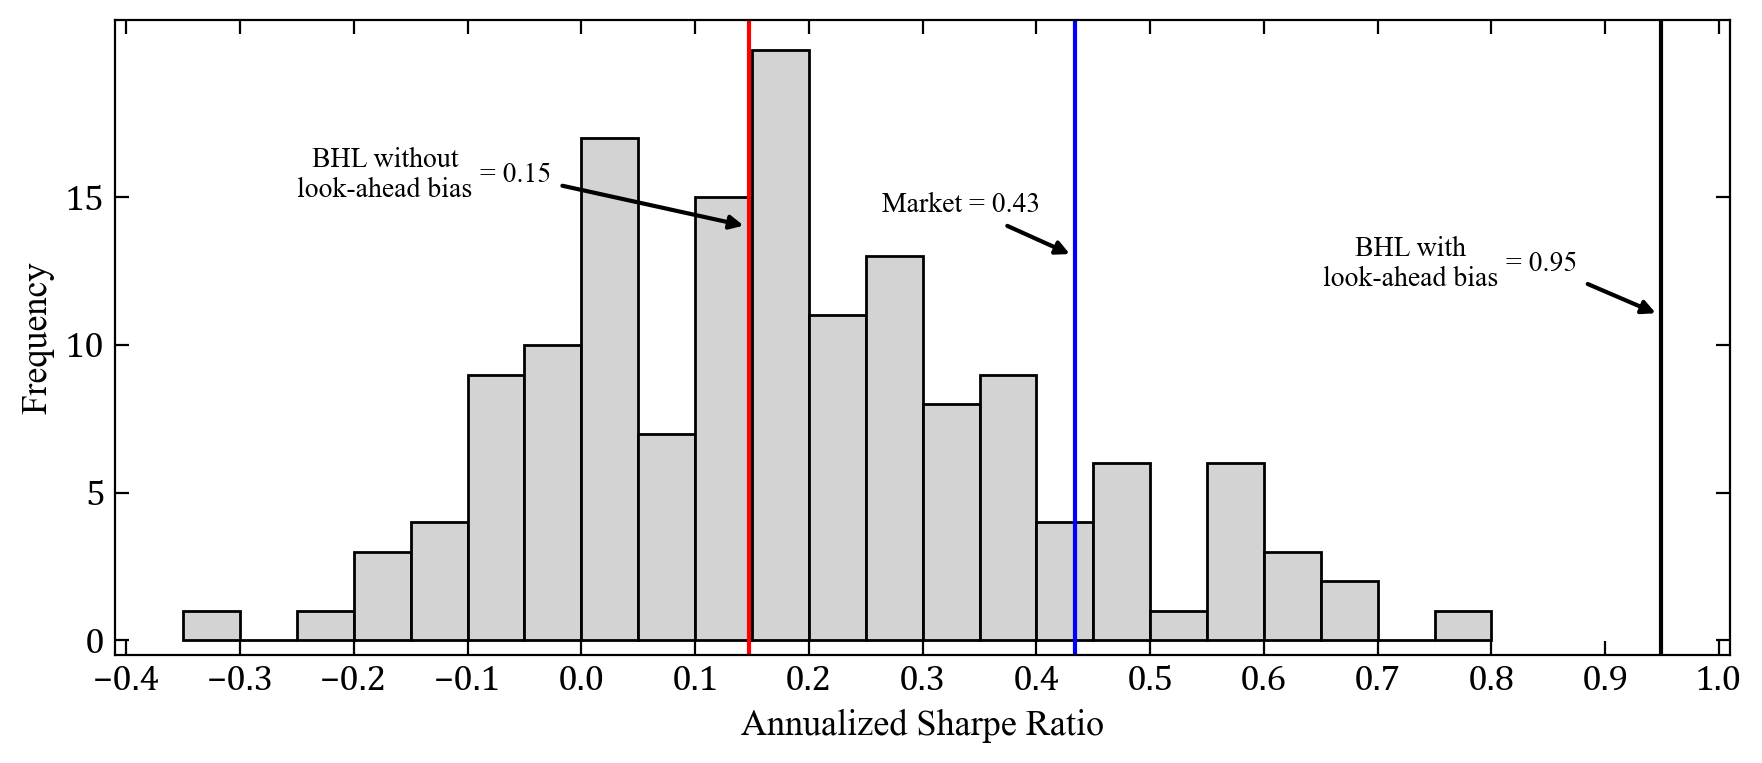

In [74]:
plt.rcParams['font.sans-serif']=['Times New Roman']
fig, ax = plt.subplots(1,1, figsize=(9,4))
sharpe_res['Sharpe'].hist(bins=np.arange(-0.35,0.81,0.05), ax=ax, color='lightgrey', edgecolor='black')
ax.tick_params(axis='x', which='both', direction='in', top=True, length=5, labelfontfamily='Cambria')
ax.tick_params(axis='y', which='both', direction='in', right=True, length=5, labelfontfamily='Cambria')
ax.set_xticks(np.arange(-0.4,1.1,0.1), )
ax.set_yticks(np.arange(0,20,5))
ax.grid(False, axis='both')
ax.set_xlabel('Annualized Sharpe Ratio')
ax.set_ylabel('Frequency')
ax.margins(x=0.01, y=0.05)
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min - 0.5, y_max)
ax.set_xlim(-0.41, 1.01)

#
arrows = [
    {"x": 0.43, "y": 15, "text": "Market = 0.43", "arrow_y": 14},
    {"x": 0.95, "y": 18, "text": "BHL with look-ahead bias = 0.95", "arrow_y": 17},
    {"x": 0.15, "y": 12, "text": "BHL without look-ahead bias = 0.09", "arrow_y": 11},
]

# Mkt
ax.axvline(Mkt, color='blue', linestyle='-')
ax.annotate(
        "Market = 0.43", xy=(Mkt, 13),
        xytext=(Mkt - 0.1, 14.5),
        arrowprops=dict(
            arrowstyle="-|>", color="black", lw=1.5
        ),   fontsize=10, ha="center",
    )


# BHL
ax.axvline(BHL, color='black', linestyle='-')
ax.text(BHL-0.22, 12, "BHL with\nlook-ahead bias", fontsize=10, ha='center')
ax.annotate(
        "= 0.95",  xy=(BHL, 11),
        xytext=(BHL - 0.105, 12.5),
        arrowprops=dict(
            arrowstyle="-|>", color="black", lw=1.5
        ),
        fontsize=10, ha="center",
    )

# RF without look-ahead bias
ax.axvline(RF, color='red', linestyle='-')
ax.text(RF-0.32, 15, "BHL without\nlook-ahead bias", fontsize=10, ha='center')
ax.annotate(
        "= 0.15",  xy=(RF, 14),
        xytext=(RF - 0.205, 15.5),
        arrowprops=dict(
            arrowstyle="-|>", color="black", lw=1.5
        ),
        fontsize=10, ha="center",
    )
plt.tight_layout()
plt.savefig('../data/Results/ASR_3.pdf', dpi=300, bbox_inches='tight')

In [69]:
sharpe_res.sort_values(by='Sharpe').tail(5)

,Var,Sharpe
91,MomSeason,0.622847
124,Tax,0.643878
69,IndRetBig,0.658423
18,CBOperProf,0.665432
92,MomSeason06YrPlus,0.778765


In [72]:
## [La Porta (1996) average return in footnote 1]
# La Port 1996 in post_2000 sample
crsp_2000 = crsp[crsp['YearMonth'] >= '2000-01-01']
df_ = crsp_2000[['permno','YearMonth','ME','bh1m']].merge(osap[['permno','YearMonth','fgr5yrLag']], on=['permno','YearMonth'], how='left')
_,vwret = utils.SingleSort(df_,
                           'permno', 'YearMonth',
                           'fgr5yrLag', 'bh1m', 5, 'ME',
                           quantile_filter=None)
utils.SingleSort_RetAna(_, vwret, 'YearMonth', factor_data=None, factor_dict={'Ret':['ones']}, lag=12, float_format='%.3f')

Var:fgr5yrLag, Delete 171530 rows due to missing values, raw data 466002 rows --> new data 294472 rows


,1,2,3,4,5,H-L
Ret,0.670,0.534,0.730,0.645,0.819,0.149
,(1.29),(1.52),(2.36),(2.15),(3.79),(0.34)
